In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

2023-07-31 19:58:50.527232: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 19:58:50.547722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# get the raw sequence
def input_file(file_path):
    """
    input is the path of fasta file
    output is a list of sequences
    """
    sequences = []
    current_sequence = ""

    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_sequence:
                    sequences.append(current_sequence)
                    current_sequence = ""
            else:
                current_sequence += line

    if  current_sequence:
        sequences.append(current_sequence)
    
    return sequences

In [3]:
# one hot encoding for the input
def one_hot_encode(seq):
    """
    input is the individual sequence
    output is the individual one-hot-encoded sequence
    """
    map = np.asarray([[1,0,0,0,0],
                      [0,1,0,0,0],
                      [0,0,1,0,0],
                      [0,0,0,1,0],
                      [0,0,0,0,1]])
    # replace ATCG with corresponding numbers
    seq = seq.upper().replace('A','\x00').replace('C','\x01').replace('G', '\x02').replace('T', '\x03').replace('N','\x04')
    seq_array = np.fromstring(seq, np.int8)
    seq_array = seq_array % 5
    encoded_seq = map[seq_array]
    
    return encoded_seq
    

In [4]:
# pad the sequence and get the input
def process_input(sequences,chunk_size):
    """
    To ensure every sequence has the same length, I pad the sequence with "N" up to the length of set chunk_size
    Then encode every sequence to get the final input for the model
    input: a list of raw sequences and chunk size
    output: the input of model (X)
    """
    padded_seq = []
    pad = ''
    for seq in sequences:
        pad = seq.ljust(chunk_size, 'N')
        padded_seq.append(pad)

    one_hot_sequences = [one_hot_encode(seq) for seq in padded_seq]
    seq_array = np.array(one_hot_sequences)
    one_hot_length = 5
    X = seq_array.reshape(-1, chunk_size, one_hot_length)
    return X

In [5]:
# translate sequence to VDJ sequence
def translate_output(df,idx):
    """
    input: the path of annotation file and the index of each item (sequence)
    output: the individual VDJ sequence like "VVVVVDDDJJJ"
    """
    # store the start, end position and length of VDJ
    # the start and end
    positions = {
    'V': [df.loc[idx, 'v_sequence_start'] - 1, df.loc[idx, 'v_sequence_end']-1],
    'D': [df.loc[idx, 'd_sequence_start'] - 1, df.loc[idx, 'd_sequence_end']-1],
    'J': [df.loc[idx, 'j_sequence_start'] - 1, df.loc[idx, 'j_sequence_end']-1],
    }
    # the length 
    for key in positions.keys():
        positions[key].append(positions[key][1] - positions[key][0]+1)
    
    # create sequence
    seq = ['X'] * (positions['J'][1] + 1)
    
    # replace the X with VDJN 
    for key, (start, end, length) in positions.items():
        seq[start:end+1] = [key] * length
    my_seq = ''.join(seq)
    my_seq = my_seq.replace('X', 'N')
    my_seq = my_seq.ljust(chunk_size, 'X')
    
    return my_seq
        

In [6]:
# one-hot-encoding for the output
def output_encoding(seq):
    """
    input: the individual VDJ sequence
    output: the individual encoded sequence
    """
    map = np.asarray([[1,0,0,0,0],
                      [0,1,0,0,0],
                      [0,0,1,0,0],
                      [0,0,0,1,0],
                      [0,0,0,0,1]])
   # replace VDJN with corresponding numbers
    seq = seq.upper().replace('V','\x00').replace('D','\x01').replace('J', '\x02').replace('N', '\x03').replace('X','\x04')
    seq_array = np.fromstring(seq, np.int8)
    seq_array = seq_array % 5
    encoded_seq = map[seq_array]
    
    return encoded_seq

In [7]:
# get the output
def process_output(df):
    """
    input: the dataframe obtained from the annotation file
    output: the one-hot-encoded target label of the model
    """
    encoded_VDJ = []
    num_VDJ = []
    for i in range(len(df)):
        seq = translate_output(df,i)
        seq_num = output_catogory(seq)
        
        num_VDJ.append(seq_num)
        encoded_seq = output_encoding(seq)
        encoded_VDJ.append(encoded_seq)
        
    y = np.array(encoded_VDJ)
    y_class = np.array(num_VDJ)
    
    return y, y_class


In [8]:
# translate the VDJ sequence to 1,2,3,4 for performance evaluation
def output_catogory(seq):
    """
    input is the individual VDJ sequence
    output is a list of numbers including 0,1,2,3,4, which respectively correspond to VDJNX
    """
    seq = seq.replace('V','\x00').replace('D','\x01').replace('J', '\x02').replace('N', '\x03').replace('X','\x04')
    return np.fromstring(seq, np.int8)

In [9]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## input and output

In [10]:
fasta_file = os.path.join('..','repertoire','first_1000.fasta')
sequences = input_file(fasta_file)
chunk_size = 450
X = process_input(sequences, chunk_size)
print(X.shape)
print(X)

(1000, 450, 5)
[[[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 0 1 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 ...

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]]


/tmp/ipykernel_478775/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [11]:
annotation_file = os.path.join('..','repertoire','first_1000.tsv')
df = pd.read_csv(annotation_file, sep='\t', header=0)
y,y_class = process_output(df)
print(y.shape)
print(y_class.shape)
print(y)

(1000, 450, 5)
(1000, 450)
[[[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 ...

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]]


/tmp/ipykernel_478775/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_478775/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


## build the model

In [33]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

No GPU devices found.


In [32]:
# create the model
sequence_length = chunk_size
one_hot_length = 5
input_shape = (sequence_length, one_hot_length)
num_classes = 5

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(Dropout(0.5))

model.add(Conv1D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(450*5, activation='softmax'))
model.add(Reshape((450,5)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=32, callbacks=[tf_callback])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 450, 16)           176       
                                                                 
 dropout_2 (Dropout)         (None, 450, 16)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 450, 8)            264       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 450, 8)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3600)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                115232    
                                                      

In [21]:
y_pred = model.predict(X_test)
y_pred[0]

array([[4.7576561e-04, 8.7554708e-10, 9.1730135e-10, 2.1718412e-09,
        1.6762749e-08],
       [5.9775909e-04, 5.9222742e-09, 9.8851338e-10, 7.1126203e-09,
        8.4963780e-10],
       [1.6481393e-03, 2.1899484e-09, 1.2043264e-09, 1.4434953e-08,
        9.0526191e-09],
       ...,
       [3.1207299e-09, 2.5399729e-09, 2.2476263e-08, 4.1397321e-09,
        2.0424444e-03],
       [1.2422809e-09, 6.8272303e-09, 2.5241225e-09, 1.2032173e-09,
        2.7315256e-03],
       [3.2602889e-09, 3.1648479e-09, 7.6678592e-09, 4.4313415e-09,
        2.0928807e-03]], dtype=float32)

Epoch 1/30
22/22 [==============================] - 0s 6ms/step - loss: 0.1632 - accuracy: 0.9333 - val_loss: 0.1680 - val_accuracy: 0.9337
Epoch 2/30
15/22 [===================>..........] - ETA: 0s - loss: 0.1635 - accuracy: 0.9333

2023-06-05 20:33:43.967175: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-06-05 20:33:43.967186: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-06-05 20:33:43.967218: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-06-05 20:33:43.973484: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-06-05 20:33:43.973983: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-06-05 20:33:43.974240: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-06-05 20:33:43.974535: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230605-151848/train/plugins/profile/202

22/22 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9340 - val_loss: 0.1604 - val_accuracy: 0.9330
Epoch 3/30
22/22 [==============================] - 0s 5ms/step - loss: 0.1585 - accuracy: 0.9346 - val_loss: 0.1586 - val_accuracy: 0.9331
Epoch 4/30
22/22 [==============================] - 0s 6ms/step - loss: 0.1559 - accuracy: 0.9346 - val_loss: 0.1562 - val_accuracy: 0.9319
Epoch 5/30
22/22 [==============================] - 0s 5ms/step - loss: 0.1614 - accuracy: 0.9340 - val_loss: 0.1628 - val_accuracy: 0.9315
Epoch 6/30
22/22 [==============================] - 0s 5ms/step - loss: 0.1542 - accuracy: 0.9355 - val_loss: 0.1537 - val_accuracy: 0.9341
Epoch 7/30
22/22 [==============================] - 0s 5ms/step - loss: 0.1539 - accuracy: 0.9344 - val_loss: 0.1623 - val_accuracy: 0.9335
Epoch 8/30
22/22 [==============================] - 0s 5ms/step - loss: 0.1581 - accuracy: 0.9340 - val_loss: 0.1636 - val_accuracy: 0.9328
Epoch 9/30
22/22 [=============

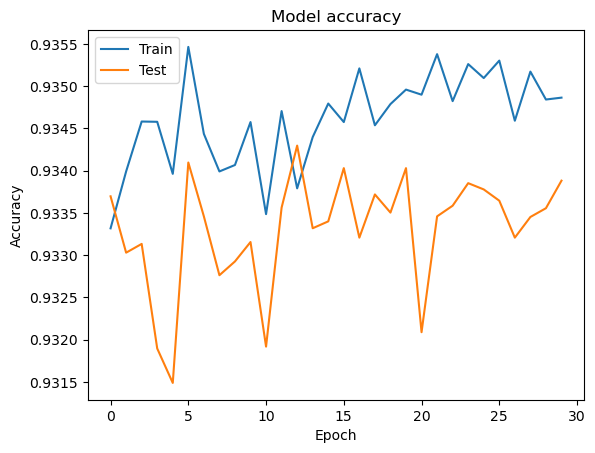

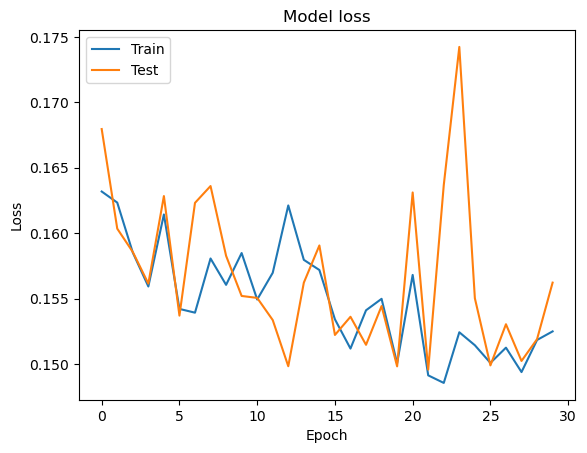

In [90]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=30, batch_size=32, callbacks=[tf_callback])

# accuracy of train and test set
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# loss of train and accuracy test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Evaluation

In [47]:
pred_classes = np.argmax(y_pred, axis=-1)
print(pred_classes[0])
print(pred_classes.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]
(300, 450)


In [55]:
y_true = np.argmax(y_test,axis=-1)
print(y_true[0])
print(y_true.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]
(300, 450)


([<matplotlib.axis.YTick at 0x7f4bb478bfd0>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

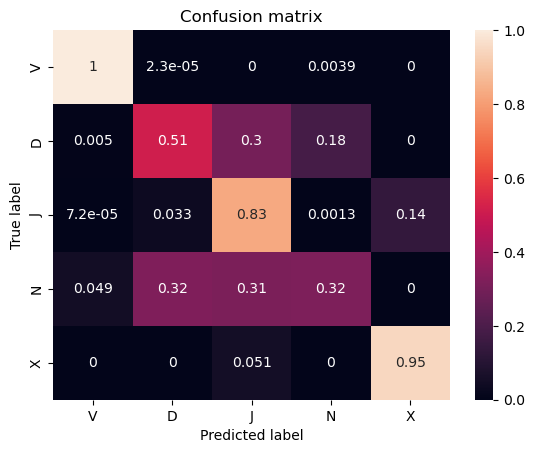

In [78]:
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N', 'X'])
labels = ['V', 'D', 'J', 'N', 'X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

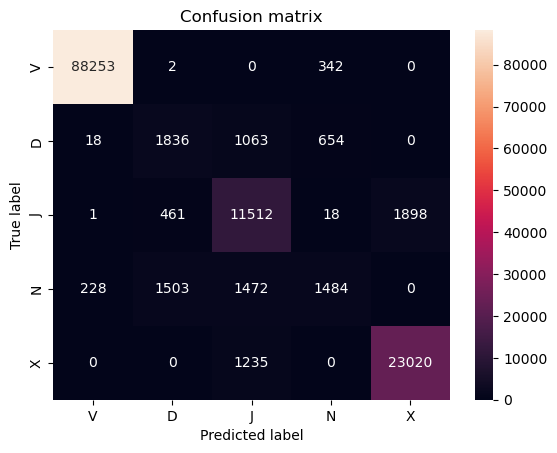

In [84]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")

labels = ['V', 'D', 'J', 'N', 'X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [60]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9341111111111111
Precision: 0.7502645477714804
Recall: 0.7209519492179248
F1 Score: 0.726663032241024


In [92]:
def ROC_curve(y_true_flat,y_pred_flat):
    # Binarize the output
    y_true_bin = label_binarize(y_true_flat, classes=[0, 1, 2, 3, 4])
    y_pred_bin = label_binarize(y_pred_flat, classes=[0, 1, 2, 3, 4])
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'blue'])
    labels = ['V', 'D', 'J', 'N', 'X']
    for i, color, label in zip(range(n_classes), colors, labels):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


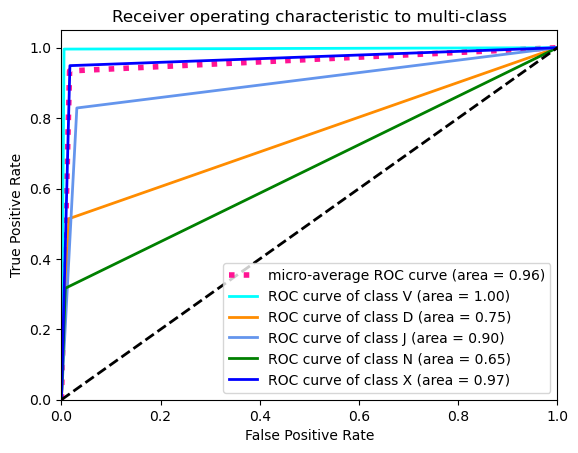

In [93]:
ROC_curve(y_true_flat,y_pred_flat)